In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import numpy as np
import xgboost as xgb
from sklearn import metrics          

import warnings
warnings.filterwarnings('ignore')
import time

%matplotlib inline

In [32]:
from IPython.display import Markdown, display
from yellowbrick.classifier import ClassificationReport
import scikitplot as skplt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

### Reading the dataset

In [3]:
# https://www.kaggle.com/omnamahshivai/surgical-dataset-binary-classification
df = pd.read_csv("E:\\dev_work\\python_projects\\xgb\\input\\surgical.csv")
df.shape

(14635, 25)

In [4]:
df.head(2)

,bmi,Age,asa_status,baseline_cancer,baseline_charlson,baseline_cvd,baseline_dementia,baseline_diabetes,baseline_digestive,baseline_osteoart,...,complication_rsi,dow,gender,hour,month,moonphase,mort30,mortality_rsi,race,complication
0,19.31,59.2,1,1,0,0,0,0,0,0,...,-0.57,3,0,7.63,6,1,0,-0.43,1,0
1,18.73,59.1,0,0,0,0,0,0,0,0,...,0.21,0,0,12.93,0,1,0,-0.41,1,0


### Class breakup

In [5]:
print ('0 % ',round(df['complication'].value_counts()[0]/len(df)*100,2))
print ('1 % ',round(df['complication'].value_counts()[1]/len(df)*100,2))

0 %  74.79
1 %  25.21


### Separation of input variables from target variable

In [6]:
feature_names = df.iloc[:, 0:len(df.columns)-1].columns
target = df.iloc[:0, len(df.columns)-1:].columns


data_features = df[feature_names]
data_target = df[target]

In [7]:
feature_names

Index(['bmi', 'Age', 'asa_status', 'baseline_cancer', 'baseline_charlson',
       'baseline_cvd', 'baseline_dementia', 'baseline_diabetes',
       'baseline_digestive', 'baseline_osteoart', 'baseline_psych',
       'baseline_pulmonary', 'ahrq_ccs', 'ccsComplicationRate',
       'ccsMort30Rate', 'complication_rsi', 'dow', 'gender', 'hour', 'month',
       'moonphase', 'mort30', 'mortality_rsi', 'race'],
      dtype='object')

In [8]:
target

Index(['complication'], dtype='object')

In [9]:
from sklearn.model_selection import train_test_split
np.random.seed(123)
X_train, X_test, y_train, y_test = train_test_split(data_features, data_target, 
                                                    train_size = 0.70, test_size = 0.30, random_state = 1)

## XGB with default

In [73]:
defaultClassifier = xgb.XGBClassifier().fit(X_train, y_train)


 ____________________ Classification Report ____________________ 

              precision    recall  f1-score   support

           0       0.98      0.90      0.94      3546
           1       0.69      0.91      0.79       845

    accuracy                           0.90      4391
   macro avg       0.83      0.91      0.86      4391
weighted avg       0.92      0.90      0.91      4391


Accuracy: 0.9048052835345024

 ____________________ Confusion Matrix ____________________ 



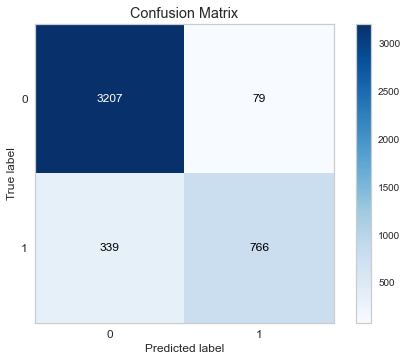

In [74]:
#Predicting for training set
defaultPred = defaultClassifier.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, defaultPred)
print("\n","__"*10,'\033[1m'+"Classification Report"+'\033[0m',"__"*10,"\n")
print(classification_report(defaultPred, y_test))

#Accuracy obtained on the training set
cm = confusion_matrix(defaultPred, y_test)
acc = cm.diagonal().sum()/cm.sum()
print ('\033[1m'+'\nAccuracy:'+'\033[0m',acc) 
print("\n","__"*10,'\033[1m'+"Confusion Matrix"+'\033[0m',"__"*10,"\n")

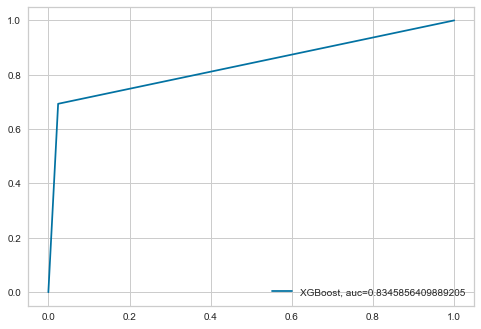

In [75]:
# AUC Curve XGBoost
y_pred_probability = defaultClassifier.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, defaultPred)
auc = roc_auc_score(y_test, defaultPred)
plt.plot(fpr,tpr,label="XGBoost, auc="+str(auc))
plt.legend(loc=4)
plt.show()

## XGBClassifier With Tuned Parameters: BayesianOptimization

In [21]:
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

import time

In [22]:
dtrain = xgb.DMatrix(X_train, label=y_train)

In [167]:
#Bayesian Optimization function for xgboost

def bo_tune_xgb(max_depth, min_split_loss , reg_alpha, min_child_weight, colsample_bytree, max_delta_step, reg_lambda,
               subsample,learning_rate,sketch_eps,refresh_leaf,scale_pos_weight,colsample_bynode,colsample_bylevel):
    params = {'max_depth': int(max_depth), 
                'min_split_loss': min_split_loss,
                'reg_alpha': reg_alpha, 
                'min_child_weight':int(min_child_weight),
                'colsample_bytree':colsample_bytree,
                'max_delta_step':max_delta_step,
                'reg_lambda':reg_lambda, 
                'subsample':subsample,
                'learning_rate': learning_rate,
                'sketch_eps': sketch_eps,
                'refresh_leaf': int(refresh_leaf),
                'scale_pos_weight': scale_pos_weight,
                'colsample_bynode': colsample_bynode,
                'colsample_bylevel': colsample_bylevel}
    #Cross validating with the specified parameters in 5 folds amin_child_weightnd 70 iterations
    cv_result = xgb.cv(params, dtrain, num_boost_round=70, nfold=5, metrics = ["rmse","auc"])
    #Return the negative RMSE
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

#Invoking the Bayesian Optimizer with the specified parameters to tune
xgb_bo = BayesianOptimization(bo_tune_xgb, {'max_depth': (0, 10),
                                            'min_split_loss': (0, 1),
                                            'reg_alpha':(0,1),
                                            'reg_lambda':(0,1),
                                            'colsample_bynode':(0, 1),
                                            'colsample_bylevel':(0, 1),
                                            'colsample_bytree':(0, 1),
                                            'min_child_weight':(0,10),
                                            'max_delta_step':(0, 1),
                                            'subsample':(0, 1),
                                            'learning_rate':(0, 0.5),
                                            'sketch_eps':(0, 1),
                                            'refresh_leaf':(0,1),
                                            'scale_pos_weight':(0,1)
                                            })

In [173]:
start_time = time.time()

xgb_bo.maximize(n_iter=50, init_points=4, acq='ei')

|   iter    |  target   | colsam... | colsam... | colsam... | learni... | max_de... | max_depth | min_ch... | min_sp... | refres... | reg_alpha | reg_la... | scale_... | sketch... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  53       | -0.395    |  0.2274   |  0.4792   |  0.8704   |  0.183    |  0.05237  |  1.436    |  4.648    |  0.5077   |  0.8185   |  0.9073   |  0.8974   |  0.8956   |  0.4877   |  0.675    |
|  54       | -0.386    |  0.797    |  0.06068  |  0.1885   |  0.1286   |  0.7737   |  7.88     |  4.169    |  0.3716   |  0.4158   |  0.274    |  0.5953   |  0.3504   |  0.9613   |  0.4766   |
|  55       | -0.3824   |  0.5388   |  0.5552   |  0.4401   |  0.1674   |  0.3576   |  3.212    |  4.572    |  0.7521   |  0.7799   |  0.29     |  0.921    |  0.2998   |  0.0377   |  0.9549   |
|  56       | -0.3408   |  0.2

In [174]:
end_time = time.time()-start_time
print('%s seconds' %(end_time))

145.3920795917511 seconds




Best Parameters selected: {'colsample_bylevel': 0.7321658457110155, 'colsample_bynode': 0.640161043427322, 'colsample_bytree': 0.7313674655252375, 'learning_rate': 0.17905661736295508, 'max_delta_step': 0.9930351812589436, 'max_depth': 6.573348464780887, 'min_child_weight': 5.203339499393072, 'min_split_loss': 0.054196470863372426, 'refresh_leaf': 0.2176815535505343, 'reg_alpha': 0.30001036901705214, 'reg_lambda': 0.6137848685710984, 'scale_pos_weight': 0.839904159103385, 'sketch_eps': 0.3299839790023603, 'subsample': 0.9715441838135858} 


____________________ Classification Report ____________________ 

              precision    recall  f1-score   support

           0       0.98      0.90      0.94      3581
           1       0.69      0.93      0.79       810

    accuracy                           0.91      4391
   macro avg       0.83      0.92      0.87      4391
weighted avg       0.93      0.91      0.91      4391


Accuracy: 0.9086768389888408

 ____________________ Confu

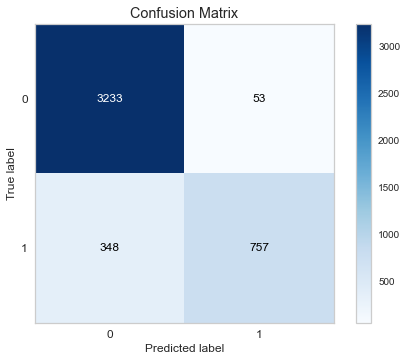

In [175]:
#Extracting the best parameters
params = xgb_bo.max['params']
print('\033[1m'+'\n\nBest Parameters selected:'+'\033[0m',params,"\n\n")
print("__"*10,'\033[1m'+"Classification Report"+'\033[0m',"__"*10,"\n")

#Converting the max_depth and n_estimator values from float to int
params['max_depth']= int(params['max_depth'])
params['refresh_leaf']= int(params['refresh_leaf'])

BOxgbModel = xgb.XGBClassifier(**params).fit(X_train, y_train)

BOxgbPred = BOxgbModel.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, BOxgbPred)

print(classification_report(BOxgbPred, y_test))

#Accuracy obtained on the training set
cm = confusion_matrix(BOxgbPred, y_test)
acc = cm.diagonal().sum()/cm.sum()
print ('\033[1m'+'\nAccuracy:'+'\033[0m',acc) 
print("\n","__"*10,'\033[1m'+"Confusion Matrix"+'\033[0m',"__"*10,"\n")

In [176]:
BOxgbModel

XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.7321658457110155,
              colsample_bynode=0.640161043427322,
              colsample_bytree=0.7313674655252375, gamma=0.0541964695,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.17905661736295508,
              max_delta_step=0.9930351812589436, max_depth=6,
              min_child_weight=5.203339499393072,
              mi...oss=0.054196470863372426, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, random_state=0, refresh_leaf=0,
              reg_alpha=0.30001036901705214, reg_lambda=0.6137848685710984,
              scale_pos_weight=0.839904159103385, sketch_eps=0.3299839790023603,
              subsample=0.9715441838135858, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [177]:
defaultClassifier

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

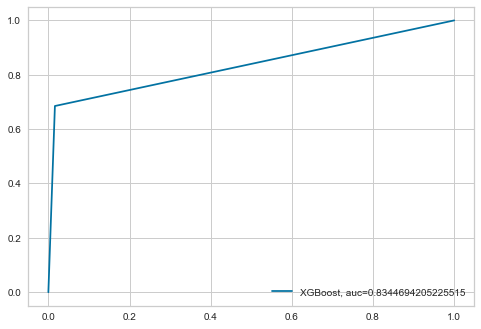

In [178]:
# AUC Curve XGBoost
y_pred_probability = BOxgbModel.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, BOxgbPred)
auc = metrics.roc_auc_score(y_test, BOxgbPred)
plt.plot(fpr,tpr,label="XGBoost, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
# Bayesian Optimisation
# Hyperopt
# GridSearch
# RandomSearch

## Hyperopt

In [28]:
import hyperopt as hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from xgboost import XGBClassifier

In [76]:
defaultClassifier

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [107]:
import random

round(random.uniform(0, 1) / 0.01) * 0.1

0.8

In [185]:
space={'max_depth': hp.quniform("max_depth", 1, 20, 1),  
        'min_split_loss': hp.quniform ('min_split_loss', 0.001,5,0.1),
        'reg_alpha' : hp.quniform('reg_alpha', 0,1,0.001),
        'reg_lambda' : hp.quniform('reg_lambda', 0,1,0.001),
        'colsample_bylevel' : hp.quniform('colsample_bylevel', 0,1,0.01),
       'colsample_bynode' : hp.quniform('colsample_bynode', 0,1,0.01),
       'colsample_bytree' : hp.quniform('colsample_bytree', 0,1,0.01),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 20, 1), 
       'max_delta_step' : hp.quniform('max_delta_step', 1, 10, 1),
       'subsample' : hp.quniform('subsample', 0, 1,0.01),
       'learning_rate' : hp.quniform('learning_rate', 0, 1,0.01),
       'sketch_eps': hp.quniform('sketch_eps', 0, 1,0.01),
       'refresh_leaf': hp.quniform('refresh_leaf', 0,1,1),
       'scale_pos_weight': hp.quniform('scale_pos_weight', 0,10,0.1)
    }

In [186]:
def hyperparameter_tuning(space):
    model = xgb.XGBClassifier(max_depth = int(space['max_depth']), 
                            min_split_loss = space['min_split_loss'],
                            reg_alpha = int(space['reg_alpha']), 
                            min_child_wight=int(space['min_child_weight']),
                            colsample_bytree=space['colsample_bytree'],
                            max_delta_step=int(space['max_delta_step']),
                            reg_lambda = space['reg_lambda'], 
                            subsample = space['subsample'],
                            learning_rate = space['learning_rate'],
                            sketch_eps = space['sketch_eps'],
                            refresh_leaf = int(space['refresh_leaf']),
                            scale_pos_weight = space['scale_pos_weight'],
                            colsample_bynode = space['colsample_bynode'],
                            colsample_bylevel = space['colsample_bylevel'])
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    model.fit(X_train, y_train,
            eval_set=evaluation, eval_metric=["auc"],
            early_stopping_rounds=10,verbose='False')

    pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5) #sklearn.metrics.f1_score(y_test, pred, average='micro') #accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    #change the metric if you like
    return {'loss': -accuracy, 'status': STATUS_OK, 'model': model}

In [187]:
trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)
print(best)

[18:14:07] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { min_child_wight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.                            


Will train until validation_1-auc hasn't improved in 10 rounds.                                                        

Stopping. Best iteration:                                                                                              
[20]	validation_0-auc:0.91324	validation_1-auc:0.86002


SCORE:                                                                                                                 
0.8011842404919153                               

In [47]:
# et = time.time() - st
# print('% seconds'%(et))

In [188]:
#Extracting the best parameters
params = best
print(params)

#Converting the max_depth and n_estimator values from float to int
params['max_depth']= int(params['max_depth'])
params['max_delta_step']= int(params['max_delta_step'])
params['min_child_weight']= int(params['min_child_weight'])
params['refresh_leaf']= int(params['refresh_leaf'])
params['objective']= 'binary:logitraw'  
#params['num_class']= 2
    
#Initialize an XGBClassifier with the tuned parameters and fit the training data
hyperoptModel = XGBClassifier(**params).fit(X_train, y_train)

#predicting for training set
hpPred = hyperoptModel.predict(X_test)

{'colsample_bylevel': 0.9400000000000001, 'colsample_bynode': 0.26, 'colsample_bytree': 0.97, 'learning_rate': 0.14, 'max_delta_step': 2.0, 'max_depth': 13.0, 'min_child_weight': 4.0, 'min_split_loss': 3.7, 'refresh_leaf': 0.0, 'reg_alpha': 0.139, 'reg_lambda': 0.992, 'scale_pos_weight': 0.8, 'sketch_eps': 0.22, 'subsample': 0.97}




Best Parameters selected: {'colsample_bylevel': 0.9400000000000001, 'colsample_bynode': 0.26, 'colsample_bytree': 0.97, 'learning_rate': 0.14, 'max_delta_step': 2, 'max_depth': 13, 'min_child_weight': 4, 'min_split_loss': 3.7, 'refresh_leaf': 0, 'reg_alpha': 0.139, 'reg_lambda': 0.992, 'scale_pos_weight': 0.8, 'sketch_eps': 0.22, 'subsample': 0.97, 'objective': 'binary:logitraw'} 


____________________ Classification Report ____________________ 

              precision    recall  f1-score   support

           0       1.00      0.89      0.94      3681
           1       0.64      0.99      0.77       710

    accuracy                           0.91      4391
   macro avg       0.82      0.94      0.86      4391
weighted avg       0.94      0.91      0.91      4391


Accuracy: 0.9063994534274653

 ____________________ Confusion Matrix ____________________ 



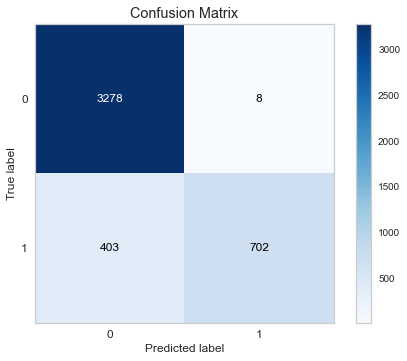

In [189]:
#Extracting the best parameters
print('\033[1m'+'\n\nBest Parameters selected:'+'\033[0m',best,"\n\n")
print("__"*10,'\033[1m'+"Classification Report"+'\033[0m',"__"*10,"\n")
skplt.metrics.plot_confusion_matrix(y_test, hpPred)

print(classification_report(hpPred, y_test))

#Accuracy obtained on the training set
cm = confusion_matrix(hpPred, y_test)
acc = cm.diagonal().sum()/cm.sum()
print ('\033[1m'+'\nAccuracy:'+'\033[0m',acc) 
print("\n","__"*10,'\033[1m'+"Confusion Matrix"+'\033[0m',"__"*10,"\n")

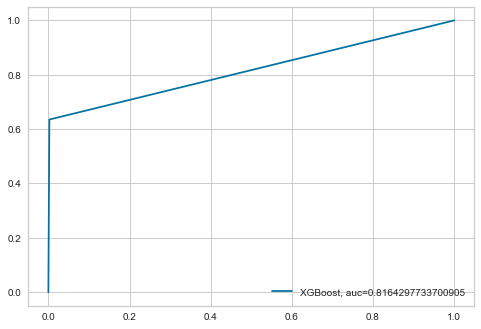

In [190]:
# AUC Curve XGBoost
y_pred_probability = hyperoptModel.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, hpPred)
auc = metrics.roc_auc_score(y_test, hpPred)
plt.plot(fpr,tpr,label="XGBoost, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [250]:
topFeatures=pd.DataFrame()
topFeatures['columns']=X_test.columns
topFeatures['importances'] = hyperoptModel.feature_importances_
topFeatures.sort_values(by='importances',ascending=False,inplace=True)

In [251]:
topFeatures

,columns,importances
13,ccsComplicationRate,0.143032
1,Age,0.140379
9,baseline_osteoart,0.118352
15,complication_rsi,0.078657
14,ccsMort30Rate,0.075493
22,mortality_rsi,0.054843
0,bmi,0.044880
12,ahrq_ccs,0.034931
16,dow,0.031973
20,moonphase,0.028738


## Explaning XGB weights

In [244]:
import shap
import matplotlib.pylab as pl

## Explain the model's predictions on the entire test dataset

In [298]:
shap_values = shap.TreeExplainer(hyperoptModel).shap_values(X_train)
explainer = shap.TreeExplainer(hyperoptModel)

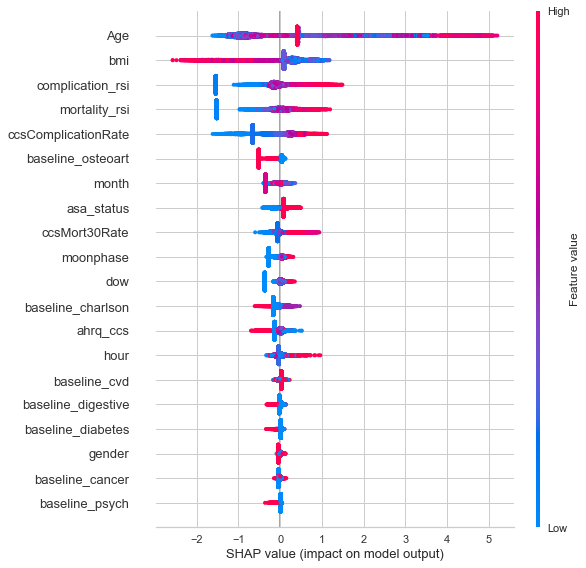

In [253]:
shap.summary_plot(shap_values, X_train)

## Interpret predictions

In [301]:
shap.initjs()

cntr_1 = 0
print("\n\t\t\t\t\t\033[1m"+"y value == 1"+"\033[0m\n")
for i,v in enumerate(y_train[:20]['complication'].tolist()):
    if v == 1 and cntr_1 < 5:
        display(shap.force_plot(explainer.expected_value, shap_values[i,:], X_train.iloc[i,:]))
        cntr_1 += 1


					y value == 1



In [300]:
shap.initjs()

cntr_1 = 0
print("\n\t\t\t\t\t\033[1m"+"y value == 0"+"\033[0m\n")
for i,v in enumerate(y_train[:20]['complication'].tolist()):
    if v == 0 and cntr_1 < 5:
        display(shap.force_plot(explainer.expected_value, shap_values[i,:], X_train.iloc[i,:]))
        cntr_1 += 1


					y value == 0



# Logistic Regression

In [193]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [194]:
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train,y_train)

# Predict
y_pred=logreg.predict(X_test)

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

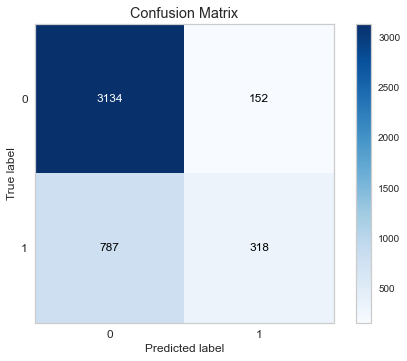

In [195]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred)

In [196]:
accuracy_score(y_test, y_pred)

0.7861534957868367

In [197]:
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.95      0.87      3286
           1       0.68      0.29      0.40      1105

    accuracy                           0.79      4391
   macro avg       0.74      0.62      0.64      4391
weighted avg       0.77      0.79      0.75      4391



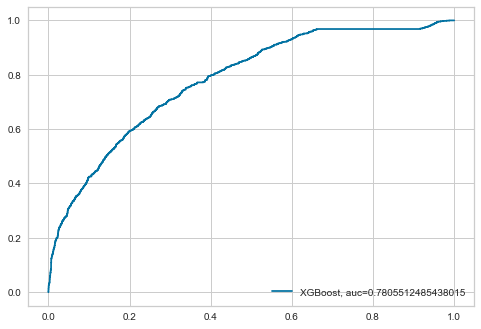

In [198]:
# AUC Curve XGBoost
y_pred_probability = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_probability)
auc = metrics.roc_auc_score(y_test, y_pred_probability)
plt.plot(fpr,tpr,label="XGBoost, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# Bagging Classifier

In [199]:
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification

In [202]:
clf = BaggingClassifier().fit(X_train,y_train)

In [203]:
BC_Pred = clf.predict(X_test)

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

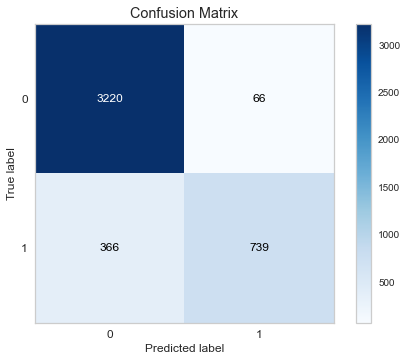

In [204]:
skplt.metrics.plot_confusion_matrix(y_test, BC_Pred)

In [205]:
accuracy_score(y_test, BC_Pred)

0.9016169437485766

In [206]:
print (classification_report(y_test, BC_Pred))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      3286
           1       0.92      0.67      0.77      1105

    accuracy                           0.90      4391
   macro avg       0.91      0.82      0.86      4391
weighted avg       0.90      0.90      0.90      4391



In [58]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://www.analyticsindiamag.com/wp-content/uploads/2019/08/bo_formula.png")